In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
import pickle

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
# I want to use neural timestamps to interp from behavior, then assign behaviors to bins

In [3]:
X_all_neural_z_vox_t = np.load("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X_all_neural_z_vox_t_correct.npy")
X_all_neural_timestamps_z_t = np.load("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X_all_neural_timestamps_z_t.npy")

In [4]:
X_all_neural_z_vox_t.shape, X_all_neural_timestamps_z_t.shape

((49, 2000, 30456), (30456, 49))

In [5]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/master_X.npy"
X = np.load(file)
X.shape

(49, 9, 2000, 3384)

In [6]:
fwd = X[:,:,250,:]
rot_pos = X[:,:,750,:]
rot_neg = X[:,:,1250,:]
del X

In [7]:
fwd = np.reshape(fwd,(49,9*3384))
rot_pos = np.reshape(rot_pos,(49,9*3384))
rot_neg = np.reshape(rot_neg,(49,9*3384))

In [8]:
X = None

In [9]:
fwd.shape

(49, 30456)

In [10]:
import gc
gc.collect()

9

In [11]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 24.56GB


In [ ]:
# because we need to do the correction for orginal z-slice, we need to loop over clusters
# so we first want to make a behavior matrix with [fly,z,behavior,time]
# we technically already have this as master_X

In [37]:
# this is too complicated for this anaylsis for now. lets do the easy way
fwd.shape, rot_pos.shape, rot_neg.shape

((49, 30456), (49, 30456), (49, 30456))

In [27]:
X_all_neural_z_vox_t.shape

(49, 2000, 30456)

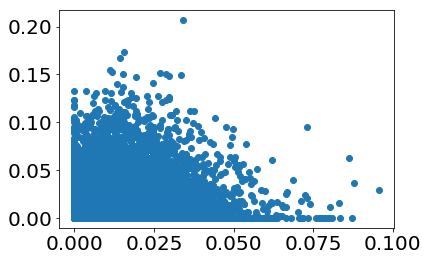

In [41]:
plt.plot(fwd[20,:], rot_pos[20,:],'o')

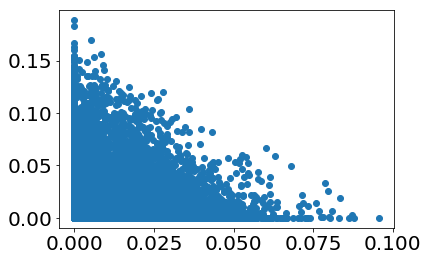

In [39]:
plt.plot(fwd[20,:], rot_neg[20,:],'o')

In [46]:
np.where(rot_pos > .075)[0].shape

(18356,)

In [49]:
np.where(rot_pos > .075)[0]

array([ 0,  0,  0, ..., 48, 48, 48])

In [47]:
np.where(rot_pos > .075)[1].shape

(18356,)

In [50]:
X_all_neural_z_vox_t[np.where(rot_pos > .075)[0], :, np.where(rot_pos > .075)[1]].shape

(18356, 2000)

In [10]:
z=20
np.where(fwd[z,:] > .03)[0].shape

(1263,)

In [16]:
np.where((fwd[z,:] > .01) &
         (fwd[z,:] <.03) &
         (rot_pos[z,:] < .01) & 
         (rot_neg[z,:] < .01))[0].shape

(1216,)

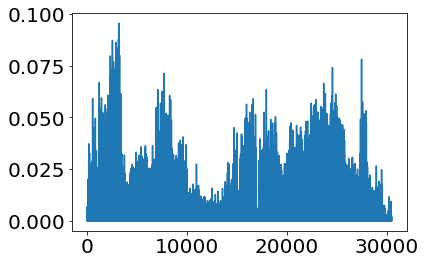

In [119]:
plt.plot(fwd[20,:])

In [12]:
mean_signals = {}
z=20

signals_fwd = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where(fwd[z,:] > .03)][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd'] = np.asarray(signals_fwd)

signals_rot_pos = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where(rot_pos[z,:] > .05)][0,:,:],axis=0)
    signals_rot_pos.append(signal)
mean_signals['rot_pos'] = np.asarray(signals_rot_pos)

signals_rot_neg = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where(rot_neg[z,:] > .05)][0,:,:],axis=0)
    signals_rot_neg.append(signal)
mean_signals['rot_neg'] = np.asarray(signals_rot_neg)

signals_fwd = []
for z in range(49):
    idx = np.where((fwd[z,:] > .01) & (fwd[z,:] <.03) & (rot_pos[z,:] < .01) & (rot_neg[z,:] < .01))
    signal = np.mean(X_all_neural_z_vox_t[z,:,idx][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd_slow'] = np.asarray(signals_fwd)

In [13]:
#####################
### Make Clusters ###
#####################
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [14]:
all_colored_by_betas = {}
for beh in ['fwd', 'rot_pos', 'rot_neg', 'fwd_slow']:
    all_colored_by_betas[beh] = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = mean_signals[beh][z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas[beh].append(colored_by_betas)
    all_colored_by_betas[beh] = np.asarray(all_colored_by_betas[beh])
    all_colored_by_betas[beh] = np.swapaxes(all_colored_by_betas[beh],0,1)
    all_colored_by_betas[beh] = np.swapaxes(all_colored_by_betas[beh],1,2)

In [15]:
################
### JFRC2018 ###
################

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)

### Down-sample jfrc to 2um isotropic
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)
#fixed_lowres = ants.resample_image(fixed,(156, 73, 46),use_voxels=True) #almost exactly 4um, but even width

In [16]:
#################
### Luke Mean ###
#################

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)

### down-sample luke_mean to func res
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [17]:
############
### WARP ###
############

out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [18]:
res_LUKE = (2.6076, 2.6154, 5.3125)
maps_voxel_res = {}
for beh in ['fwd', 'rot_pos', 'rot_neg', 'fwd_slow']:
    moving = ants.from_numpy(all_colored_by_betas[beh][:,:,::-1])
    moving.set_spacing(res_LUKE)
    maps_voxel_res[beh] = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0])

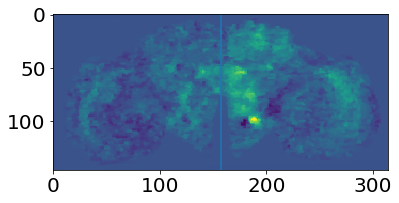

In [19]:
plt.imshow(maps_voxel_res['rot_neg'][:,:,50].T)
plt.axvline(314/2)

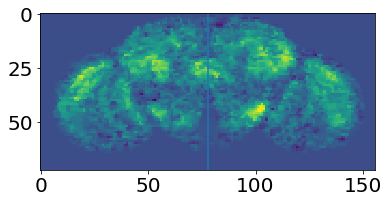

In [153]:
plt.imshow(maps_voxel_res['fwd_slow'][:,:,30].T)
plt.axvline(156/2)

In [131]:
maps_voxel_res['fwd_slow'].shape

(156, 73, 46)

In [43]:
diff_map1 = maps_voxel_res['fwd_slow']-maps_voxel_res['fwd']
diff_map2 = (maps_voxel_res['fwd_slow']-maps_voxel_res['fwd'])
diff_map2 = diff_map2[::-1,:,:]
diff_map = (diff_map1+diff_map2)/2

In [19]:
diff_map1 = maps_voxel_res['fwd_slow']-maps_voxel_res['rot_pos']
diff_map2 = (maps_voxel_res['fwd_slow']-maps_voxel_res['rot_neg'])
diff_map2 = diff_map2[::-1,:,:]
diff_map = (diff_map1+diff_map2)/2

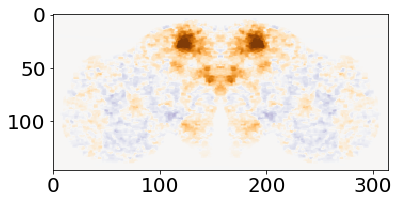

In [46]:
plt.imshow(diff_map2[:,:,50].T,vmin=-.1,vmax=.1,cmap='PuOr')

In [20]:
### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)
#atlas = ants.resample_image(atlas,(256,128,49),use_voxels=True)

(-0.5, 313.5, 145.5, -0.5)

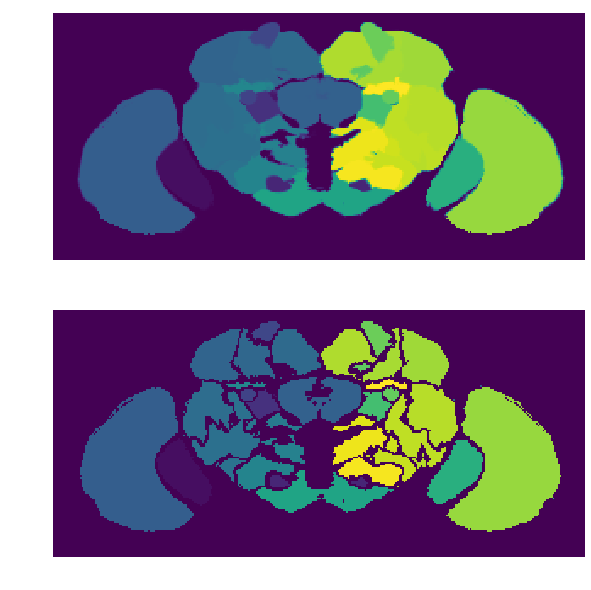

In [21]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [22]:
####################################
### FOR SINGLE MAP (ie, not RGB) ###
####################################

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # use this for plotting clusters
#         # temporal
#         masked_roi = mask_dilated*np.nan_to_num(to_plot_new)#*temporal_map #CORR
#         #masked_roi = mask_dilated*np.nan_to_num(corr)#*temporal_map #CORR

#         masked_roi_flat = np.max(masked_roi,axis=2)
#         roi_data.append(masked_roi_flat)
        #print(np.sum())
        
        #PCA or any diverging (Turn off if above is on) <---------------
        masked_roi = mask_dilated*np.nan_to_num(corr)
        maxs = np.max(masked_roi,axis=2)
        mins = np.min(masked_roi,axis=2)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
        masked_roi_flat = maxs
        roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
        
    #for plotting clusters
#     roi_datas = np.max(np.asarray(roi_data),axis=0)
#     data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA (Turn off if above is on) <---------------
    roi_data = np.asarray(roi_data)
    maxs = np.max(roi_data,axis=0)
    mins = np.min(roi_data,axis=0)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
    data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=-1 #changed from 1 to -1 so can use set_under to pick specific color
    else:
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] += to_plot #made this +=
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [23]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

In [40]:
diff_map

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

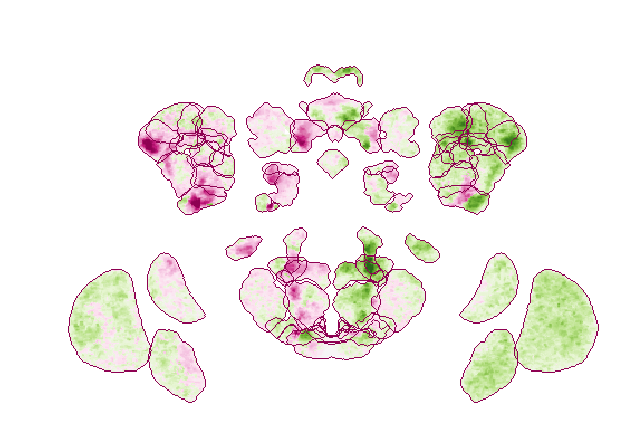

In [24]:
# canvi = []
# for n in tqdm(range(1,5)):
#     cN = np.where(np.asarray(cluster_reassignment)==n)[0]+1
#     corr = to_plot.copy()
#     corr[np.where((to_plot<cN[0]) | (to_plot>cN[-1]))]=np.nan

corr = diff_map.numpy().copy()
input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)

canvas[np.where(canvas==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap='PiYG',vmin=-.1,vmax=.1)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [25]:
diff_map.shape

(314, 146, 91)

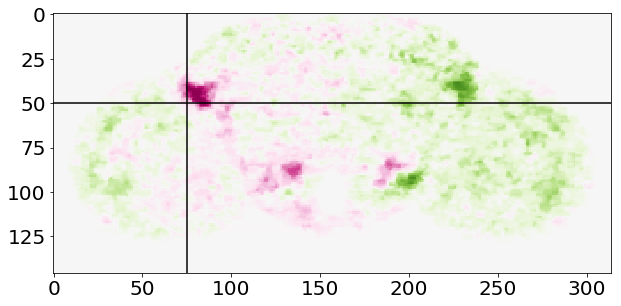

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(diff_map[:,:,63].T,cmap='PiYG',vmin=-.1,vmax=.1)
plt.axhline(50,color='k')
plt.axvline(75,color='k')

In [38]:
import matplotlib

In [44]:
cmap = matplotlib.cm.get_cmap('cet_gwv')

In [40]:
cmap.set_under('k')
cmap.set_bad('w')


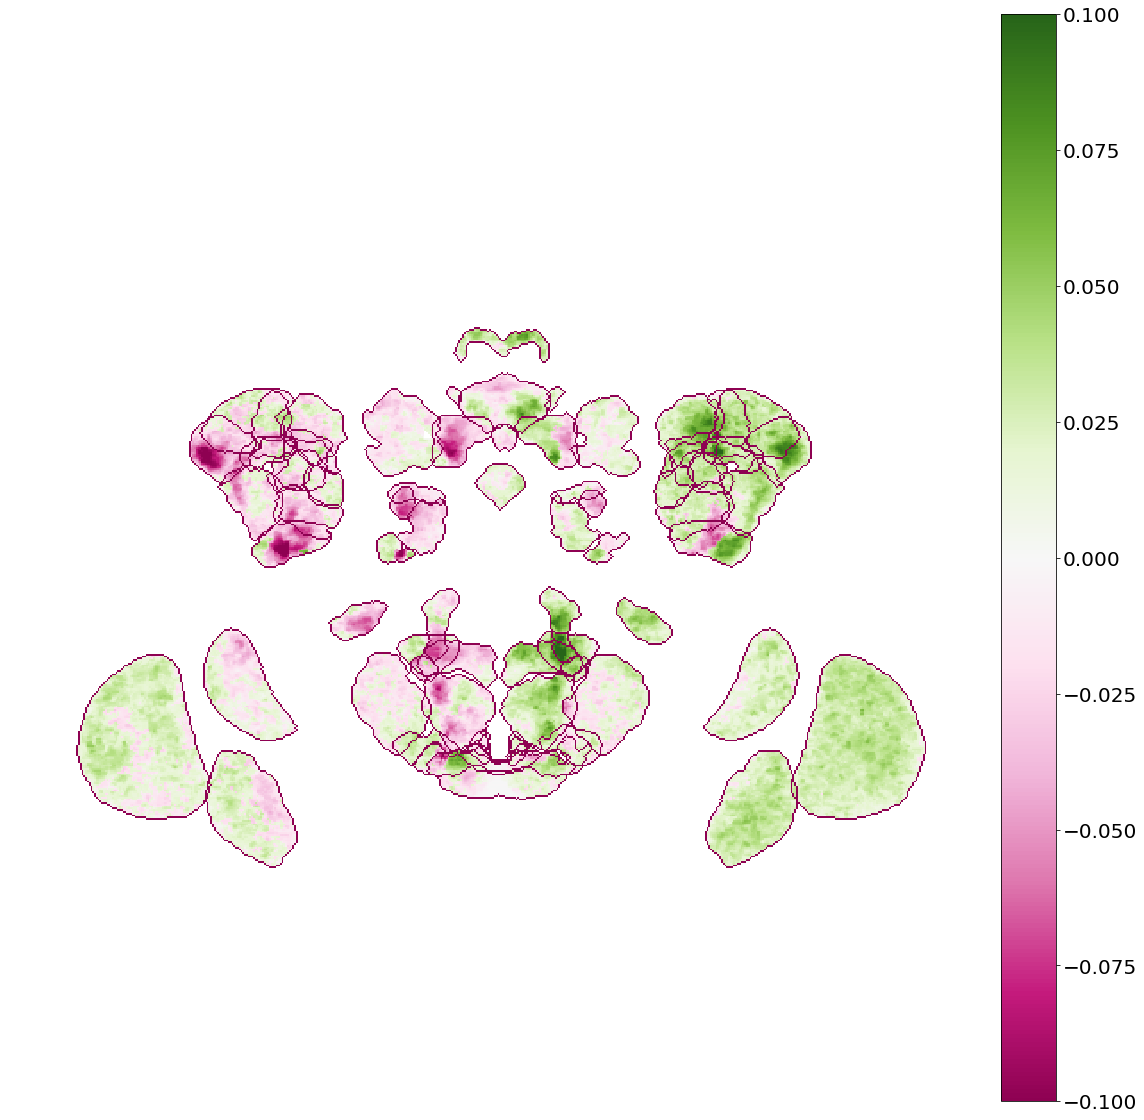

In [57]:
plt.figure(figsize=(20,20))
plt.imshow(canvas[150:,:],cmap='PiYG',vmin=-.1,vmax=.1)
plt.colorbar()
plt.axis('off')
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [28]:
import colorcet as cc

In [106]:
all_colored_by_betas['fwd'].shape
#256, 128, 49

(49, 256, 128)

In [ ]:
np.roll(all_colored_by_betas['fwd']).shape


(-0.5, 255.5, 127.5, -0.5)

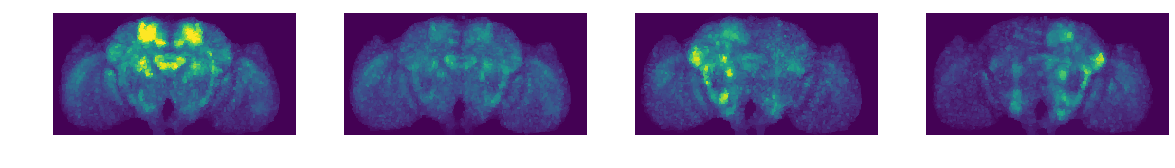

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(np.max(all_colored_by_betas['fwd'],axis=0).T,vmin=0,vmax=.2)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(np.max(all_colored_by_betas['fwd_slow'],axis=0).T,vmin=0,vmax=.2)
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(np.max(all_colored_by_betas['rot_pos'],axis=0).T,vmin=0,vmax=.2)
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(np.max(all_colored_by_betas['rot_neg'],axis=0).T,vmin=0,vmax=.2)
plt.axis('off')

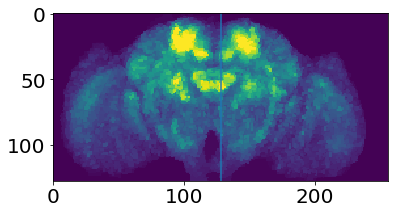

In [102]:
plt.imshow(np.max(all_colored_by_betas['fwd'],axis=0).T,vmin=0,vmax=.2)
plt.axvline(128)

In [97]:
diff_map1 = all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_pos']
diff_map2 = (all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_neg'])
diff_map2 = diff_map2[:,::-1,:]
diff_map = (diff_map1+diff_map2)/2
diff_map.shape

(49, 256, 128)

In [98]:
maxs = np.max(diff_map,axis=0)
mins = np.min(diff_map,axis=0)
maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]

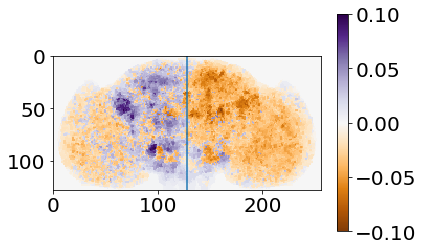

In [100]:
plt.imshow(maxs.T*-1,cmap='PuOr',vmin=-.1,vmax=.1)
plt.axvline(128)
plt.colorbar()

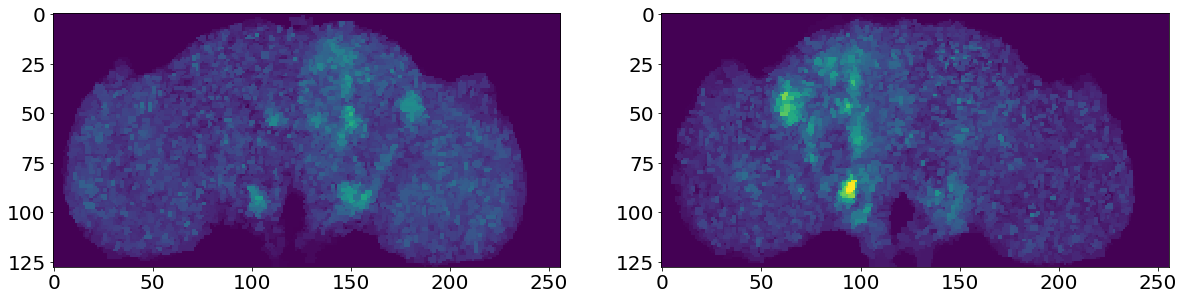

In [36]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(np.max(all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_pos'],axis=0).T,vmin=0,vmax=.2)
plt.subplot(1,2,2)
plt.imshow(np.max((all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_pos'])*-1,axis=0).T,vmin=0,vmax=.2)


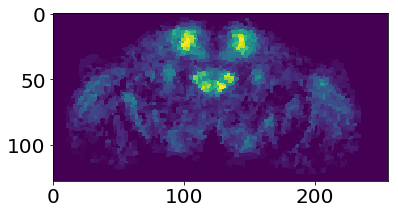

In [33]:
plt.imshow(all_colored_by_betas['fwd'][20,:,:].T,vmin=0,vmax=.2)

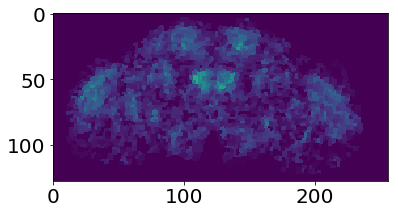

In [32]:
plt.imshow(all_colored_by_betas['fwd_slow'][20,:,:].T,vmin=0,vmax=.2)

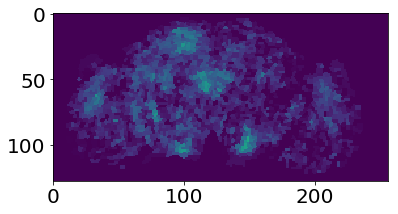

In [34]:
plt.imshow(all_colored_by_betas['rot_pos'][20,:,:].T,vmin=0,vmax=.2)

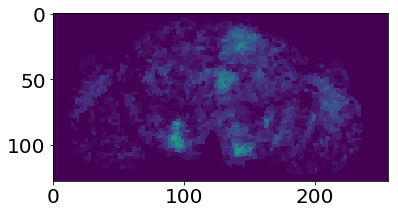

In [35]:
plt.imshow(all_colored_by_betas['rot_neg'][20,:,:].T,vmin=0,vmax=.2)

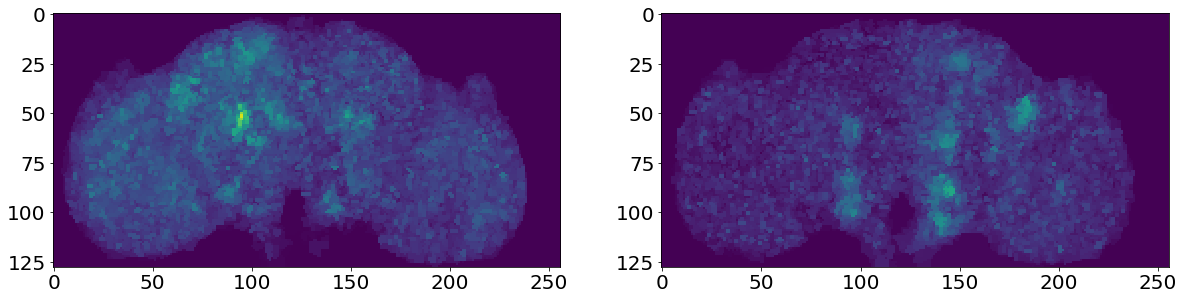

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(np.max(all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_neg'],axis=0).T,vmin=0,vmax=.2)
plt.subplot(1,2,2)
plt.imshow(np.max((all_colored_by_betas['fwd_slow']-all_colored_by_betas['rot_neg'])*-1,axis=0).T,vmin=0,vmax=.2)


# Draw bounding boxes on 2d behavior hist

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [3]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)
            
            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1
            
            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)
            
            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [4]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [5]:
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 58.80 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.31 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 55.12 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.88 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 58.09 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.42 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 61.41 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.21 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 65.47 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.35 sec
*** fly: f

In [6]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y', 'Y_pos']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z', 'Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [7]:
YZ = np.sqrt(np.power(behavior_super['Y_std'],2), np.power(behavior_super['Z_std'],2))

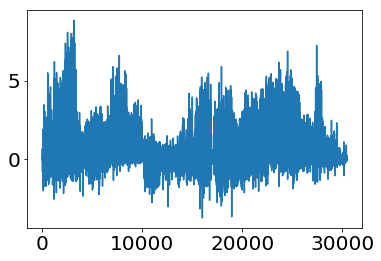

In [132]:
plt.plot(behavior_super['Y_std'])

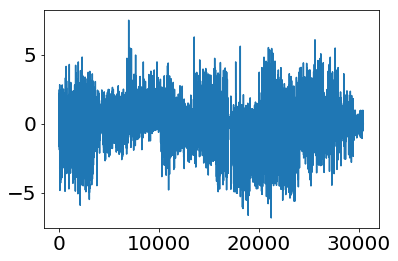

In [133]:
plt.plot(behavior_super['Z_std'])

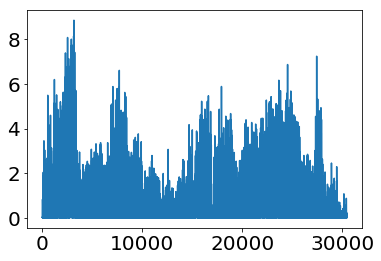

In [131]:
plt.plot(YZ)

In [124]:
np.std(behavior_super['Y'])

0.010789193260969974

In [126]:
np.std(behavior_super['Z'])

0.027563803888671537

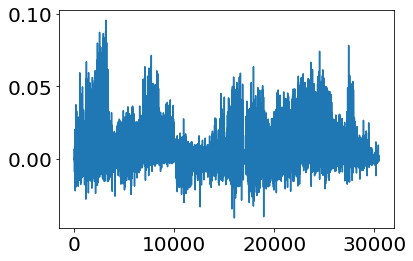

In [123]:
plt.plot(behavior_super['Y'])

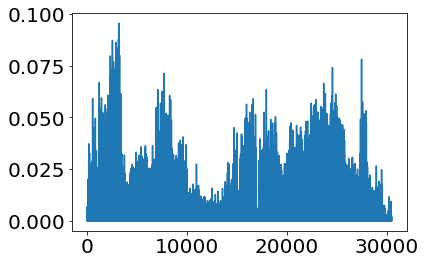

In [120]:
plt.plot(fwd[20,:])

In [8]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    #"PC" is just a holdover
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    #bins_x = np.concatenate((np.linspace(start_x,0,num_bins_x)[:-1], np.linspace(0,end_x,num_bins_x)))
    #bins_y = np.concatenate((np.linspace(start_y,0,num_bins_y)[:-1], np.linspace(0,end_y,num_bins_y)))
    
#     bins_x = [x / 10.0 for x in range(-20, 64, 4)]
#     bins_y = [x / 10.0 for x in range(-40, 44, 4)]
#     num_bins_x = 22
#     num_bins_y = 22
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    
    # Hide bins containing too few data points
    #test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], test['pc_count'], bins_x, bins_y

In [9]:
from matplotlib.colors import LogNorm

In [10]:
from matplotlib import colors
import matplotlib.patches as patches


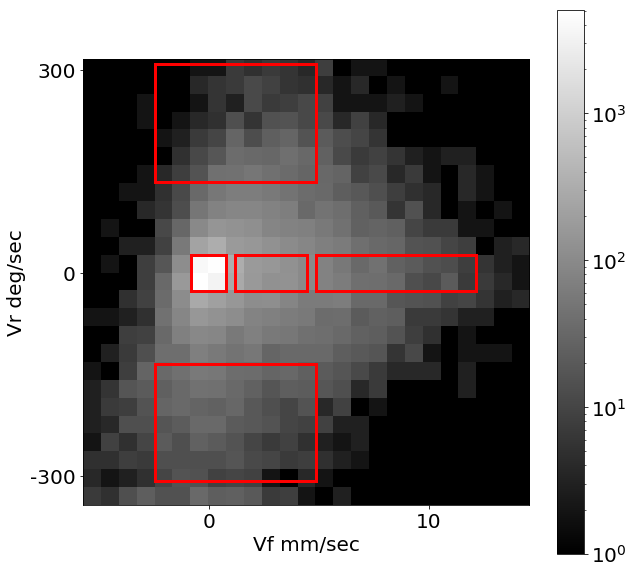

In [11]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

signal = np.ones(30456)#fwd_resp#temporal[:,k]
#plt.subplot(5,5,k+1)
fictrac_2d, bin_cnt, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=25, num_bins_y=25,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)

bin_cnt[np.where(bin_cnt==0)]=1
plt.imshow(bin_cnt,cmap='gray',extent=[-2.35,6,-4.35,4],norm=colors.LogNorm()) #.2
plt.colorbar()
#plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

ax = plt.gca()

rect = patches.Rectangle((-1/3, -1/3), 2/3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((0.5, -1/3), 1+1/3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((2, -1/3), 3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((-1, 1.7), 3, 2.2, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((-1, -3.9), 3, 2.2, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
ax.set_yticklabels([-300, 0, 300])
ax.set_yticks([-300*ratio, 0, 300*ratio])

ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
ax.set_xticklabels([0, 10])
ax.set_xticks([0, 10*ratio])

plt.ylabel('Vr deg/sec')
plt.xlabel('Vf mm/sec')

#plt.colorbar()

#ax.axhline(0,linestyle='--',color='k',linewidth=1)
#ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

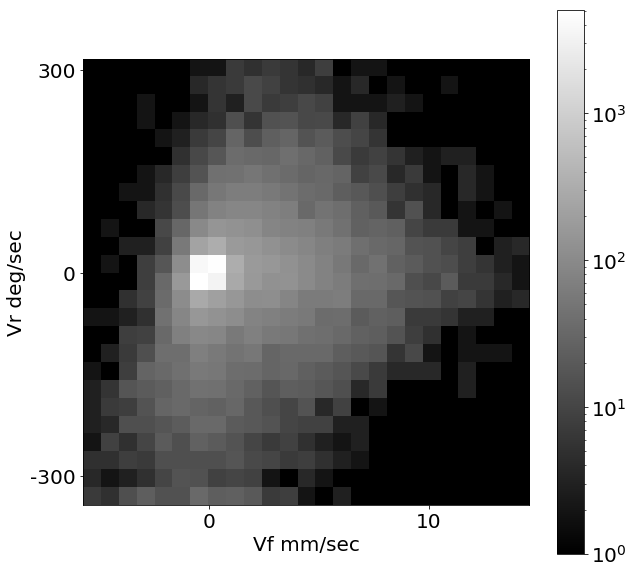

In [13]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

signal = np.ones(30456)#fwd_resp#temporal[:,k]
#plt.subplot(5,5,k+1)
fictrac_2d, bin_cnt, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                 num_bins_x=25, num_bins_y=25,
                                 start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                 min_num_samples=9)

bin_cnt[np.where(bin_cnt==0)]=1
plt.imshow(bin_cnt,cmap='gray',extent=[-2.35,6,-4.35,4],norm=colors.LogNorm()) #.2
plt.colorbar()
#plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

ax = plt.gca()

# rect = patches.Rectangle((-1/3, -1/3), 2/3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# rect = patches.Rectangle((0.5, -1/3), 1+1/3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# rect = patches.Rectangle((2, -1/3), 3, 2/3, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# rect = patches.Rectangle((-1, 1.7), 3, 2.2, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# rect = patches.Rectangle((-1, -3.9), 3, 2.2, linewidth=3, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
ax.set_yticklabels([-300, 0, 300])
ax.set_yticks([-300*ratio, 0, 300*ratio])

ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
ax.set_xticklabels([0, 10])
ax.set_xticks([0, 10*ratio])

plt.ylabel('Vr deg/sec')
plt.xlabel('Vf mm/sec')

#plt.colorbar()

#ax.axhline(0,linestyle='--',color='k',linewidth=1)
#ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight', transparent=True)

In [230]:
### these thresh match the boxes above ###

mean_signals = {}

f = behavior_super['Y_std']
r = behavior_super['Z_std']

signals_stop = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where((f > -1/3) & (f < 1/3) & (r < 1/3) & (r > -1/3))][0,:,:],axis=0)
    signals_stop.append(signal)
mean_signals['stop'] = np.asarray(signals_stop)

signals_fwd = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where((f > 2) & (f < 5) & (r < 1/3) & (r > -1/3))][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd'] = np.asarray(signals_fwd)

signals_rot_pos = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where((f > -1) & (f < 3) & (r > 1.7) & (r < 5))][0,:,:],axis=0)
    signals_rot_pos.append(signal)
mean_signals['rot_pos'] = np.asarray(signals_rot_pos)

signals_rot_neg = []
for z in range(49):
    signal = np.mean(X_all_neural_z_vox_t[z,:,np.where((f > -1) & (f < 3) & (r > -5) & (r < -1.7))][0,:,:],axis=0)
    signals_rot_neg.append(signal)
mean_signals['rot_neg'] = np.asarray(signals_rot_neg)

signals_fwd = []
for z in range(49):
    idx = np.where((f > 0.5) & (f < 1.5+1/3) & (r < 1/3) & (r > -1/3))
    signal = np.mean(X_all_neural_z_vox_t[z,:,idx][0,:,:],axis=0)
    signals_fwd.append(signal)
mean_signals['fwd_slow'] = np.asarray(signals_fwd)

In [231]:
all_colored_by_betas = {}
for beh in ['stop', 'fwd', 'fwd_slow', 'rot_pos' ,'rot_neg']:
    all_colored_by_betas[beh] = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = mean_signals[beh][z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas[beh].append(colored_by_betas)
    all_colored_by_betas[beh] = np.asarray(all_colored_by_betas[beh])
    all_colored_by_betas[beh] = np.swapaxes(all_colored_by_betas[beh],0,1)
    all_colored_by_betas[beh] = np.swapaxes(all_colored_by_betas[beh],1,2)

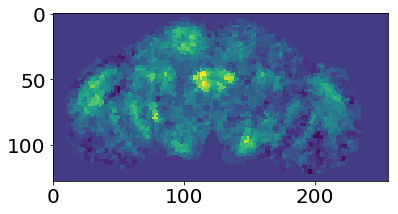

In [208]:
plt.imshow(all_colored_by_betas['rot_pos'][:,:,20].T)

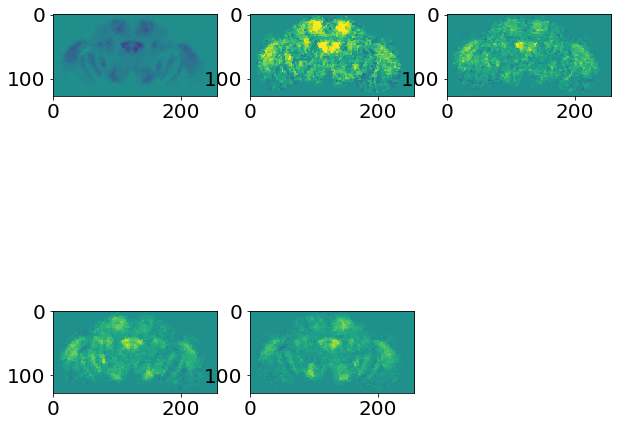

In [209]:
plt.figure(figsize=(10,10))
for i,beh in enumerate(['stop', 'fwd', 'fwd_slow', 'rot_pos' ,'rot_neg']):
    plt.subplot(2,3,i+1)
    plt.imshow(all_colored_by_betas[beh][:,:,20].T,vmin=-.1,vmax=.1)

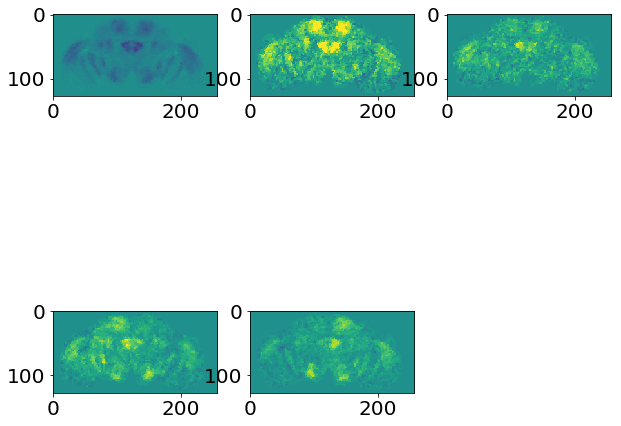

In [196]:
plt.figure(figsize=(10,10))
for i,beh in enumerate(['stop', 'fwd', 'fwd_slow', 'rot_pos' ,'rot_neg']):
    plt.subplot(2,3,i+1)
    plt.imshow(all_colored_by_betas[beh][:,:,20].T,vmin=-.1,vmax=.1)

In [232]:
res_LUKE = (2.6076, 2.6154, 5.3125)
maps_voxel_res = {}
for beh in ['stop', 'fwd', 'rot_pos', 'rot_neg', 'fwd_slow']:
    moving = ants.from_numpy(all_colored_by_betas[beh][:,:,::-1])
    moving.set_spacing(res_LUKE)
    maps_voxel_res[beh] = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0])

In [233]:
diff_map1 = maps_voxel_res['fwd_slow']-maps_voxel_res['rot_pos']
diff_map2 = (maps_voxel_res['fwd_slow']-maps_voxel_res['rot_neg'])
diff_map2 = diff_map2[::-1,:,:]
diff_map = (diff_map1+diff_map2)/2

In [241]:
diff_map = maps_voxel_res['fwd']-maps_voxel_res['fwd_slow']

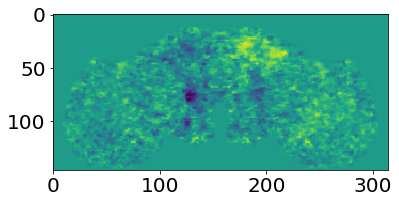

In [212]:
plt.imshow(diff_map[:,:,40].T)

In [127]:
# for walking vectors, I picked 0.2 as thresh. This unit is in std of a joint fwd rot vector
# simplify to assume 0.2 fwd std thresh

45.0

In [116]:
# If I pick a fwd value of 5mm/sec, I can find the edge of the box with
unit_value = 5
ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
unit_value*ratio

# conversely, if I want to get the real unit value from a threshold
thresh_value = 1/3
thresh_value/ratio

0.8091894945727479

In [117]:
unit_value = 1
ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
unit_value*ratio

0.41193482561131534

In [138]:
# lets make our thresholds in std space, so they can be easily compared between fwd and turn

stopped_thresh = 1/3 #std
# what is this in unit space?
ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
print(stopped_thresh/ratio)
ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
print(stopped_thresh/ratio)


0.8091894945727479
26.321493835786086


In [135]:
4/ratio

9.710273934872976